# Interactive visualization in *yt* using Napari and Dask

In this notebook, we demonstrate a workflow that leverages napari's interactive visualization strengths to  explore a data set loaded and sampled via *yt*. We start with generating a set of in-memory frames using *yt* that we hand off to napari for visualization and then use dask to build a lazy-loading stack of *yt* images. 

The inspiration for this notebook came from watching 'Interactive Image Processing at Scale' from the folks at Coiled and guests Nicholas Sofroniew and Talley Lambert, who presented their work on using napari and dask to load and process multi-resolution images of cells ([check out the video here](https://www.youtube.com/watch?v=KG_ye5qzFmk)). In it, Sofroniew and Lambert present some surprisingly simply notebooks that leverage dask's lazy loading and block mapping to define loading and processing functions that get triggered on demand by napari as the user needs it. The notebooks are availabe [here](https://github.com/tlambert03/napari-dask-example) and the "lazy just in time io" and "lazy pre-processing with dask.map_blocks" sections in [this notebook](https://github.com/tlambert03/napari-dask-example/blob/master/dask_napari.ipynb) are particularly illustrative in laying out the approach of the present notebook. 


##  general approach

Ultimately, loading data into napari is as simple as:

```
viewer = napari.view_image(image_stack)
```

where `image_stack` is an array object. We'll start with the simplest case in which `image_stack` is an in-memory image array generated by storing images created from *yt* slices and then demonstrate a lazy loading approach with dask. 

## section overview
**1. Viewing an in-memory *yt* image stack  in napari**: Loads a series of yt image slices into memory, loads the image stack in napri (initially slow, then fast)
**2. Viewing a lazy-processed dask-yt image stack in napari**: Wraps the yt image slicing in dask to load on demand in napari (a little slow)
**3. Viewing a lazy-loaded dask-*yt* image stack from pre-computed *yt* slices in napari**: uses dask's distributed computing module to pre-compute and save yt image slices then uses dask to lazy-load the slices in napari. (initially slow, then fa
**4. one more approach with yt's fixed resolution buffer**: similar to section 2, but uses *yt*'s fixed resolution buffer method to pull out array values for each slice (fast!)
## requirements 

Running this notebook requires: yt, napari and dask in addition to standard libraries in the scientific python stack. Section 3 makes use of dask distributed computing, which requires a slightly modified install: `pip install dask[distributed]`. If you don't want to run Section 3, you can comment out the `from dask.distributed import Client, progress` import and use the standard dask install throughout the rest of the notebook. 

so let's just import everything we'll need. 


In [32]:
 # for napari, do it first!
%gui qt

In [33]:
# general imports
import numpy as np
import matplotlib.pyplot as plt 
import os

# yt related
import yt
from yt.units import kpc

# napari related imports 
import napari
from napari.utils import nbscreenshot
import logging

# dask imports 
from dask import delayed, compute
import dask.array as da
from dask.distributed import Client, progress


## Test data 

We'll use a standard yt test ENZO dataset, `IsolatedGalaxy`, (download [here](http://yt-project.org/data/IsolatedGalaxy.tar.gz)).

So let's just load up the data and slice it as usual in *yt*: 

In [34]:
ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030") 
slc = yt.SlicePlot(ds, 'z', 'density', center=[0.5, 0.5, 0.5],width=(20,'kpc'))

Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 17620.99it/s]



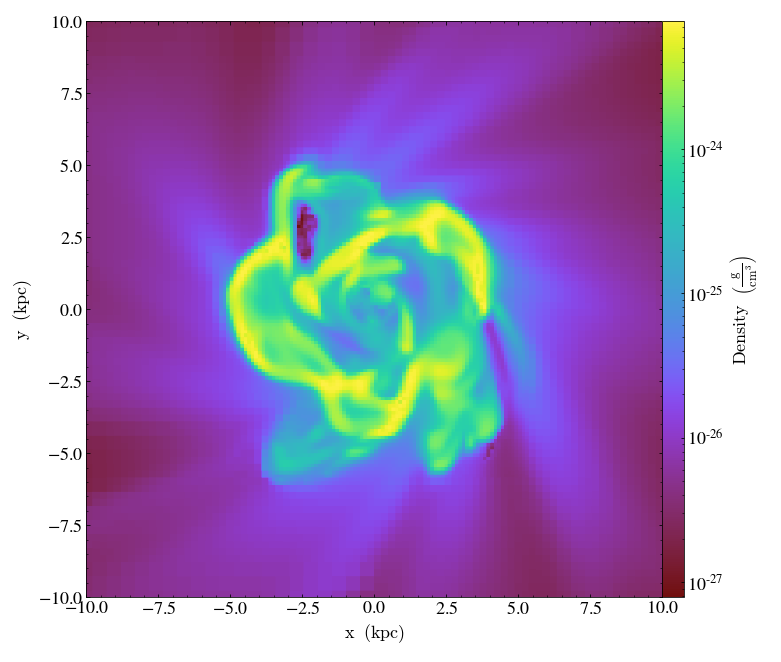

In [35]:
slc.show()

## Storing *yt* images as an array 

In order to load *yt* images into napari, we need to be able to store the above image as a numpy array. While we could simply use `slc.save()` to save off the image then reload with something like matplotlib's `imread`, that introduces an extra io step. 

*yt* does have a method `FixedResolutionBuffer` to generate the 2D image array of a slice [see here](https://yt-project.org/doc/analyzing/generating_processed_data.html#d-image-arrays), but in this notebook it's nice to preserve the axes notations, so we're going to access the slice's `matplotlib` canvas directly as follows: 

In [5]:
canvas = slc.plots[('gas', 'density')].canvas
s, (width, height) = canvas.print_to_buffer()
X = np.frombuffer(s, np.uint8).reshape((height, width, 4))

Let's make sure it worked using matplotlib's `imshow`: 

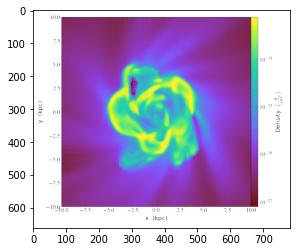

In [6]:
plt.imshow(X)

So it works. Don't worry about the double axes... we still want the inner axes generated by *yt* in the final napari output, so we don't want to turn those off, and napari won't generate the additional axes. 

## 1. Viewing an in-memory *yt* image stack  in napari 

So let's build a stack of images to load into napari, without worrying about dask yet.

We'll create a sequaential sectioning of our 3D dataset by varying the `z` value that the slice is taken at. So let's define a range of z values to traverse:

In [36]:
z_dist=.001
Nframes = 50
z_vals = np.linspace(0.5-z_dist,0.5+z_dist,Nframes)

the first `z_val` will look like:


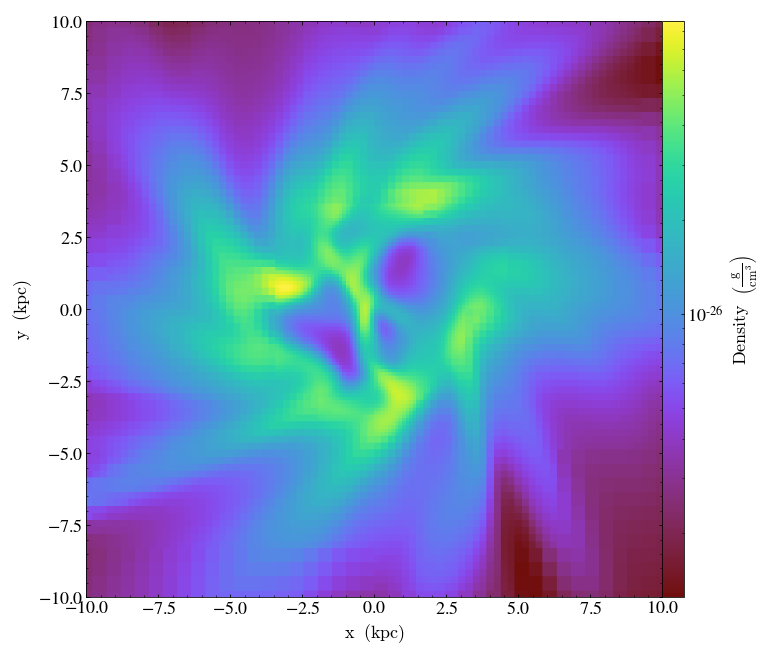

In [37]:
slc = yt.SlicePlot(ds, 'z', 'density', center=[0.5, 0.5, z_vals[0]],width=(20,'kpc'))
slc.show()

Ok, so now let's loop over the `z_vals` and store a ndarray for each frame. First, we'll turn off the yt logging so we don't get too much output, and then we'll loop over the `z_vals` and store the image arrays in a `frame_list` that we convert to a numpy array in the end. (Note: it takes about 30 seconds to build the 50 frames). 

In [38]:
yt.funcs.mylog.setLevel(50)

In [39]:
%%time 
frame_list = []
for zval in z_vals:
    slc = yt.SlicePlot(ds, 'z', 'density', center=[0.5, 0.5, zval],width=(20,'kpc'))
    canvas = slc.plots[('gas', 'density')].canvas
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    frame_list.append(np.frombuffer(s, np.uint8).reshape((height, width, 4)))
frame_list= np.array(frame_list)


CPU times: user 23.3 s, sys: 603 ms, total: 23.9 s
Wall time: 23.8 s


We now have a 4-d numpy array:

In [40]:
frame_list.shape

(50, 662, 781, 4)

Loading this into napari is **very** easy... First, we initialize an empty `Viewer`

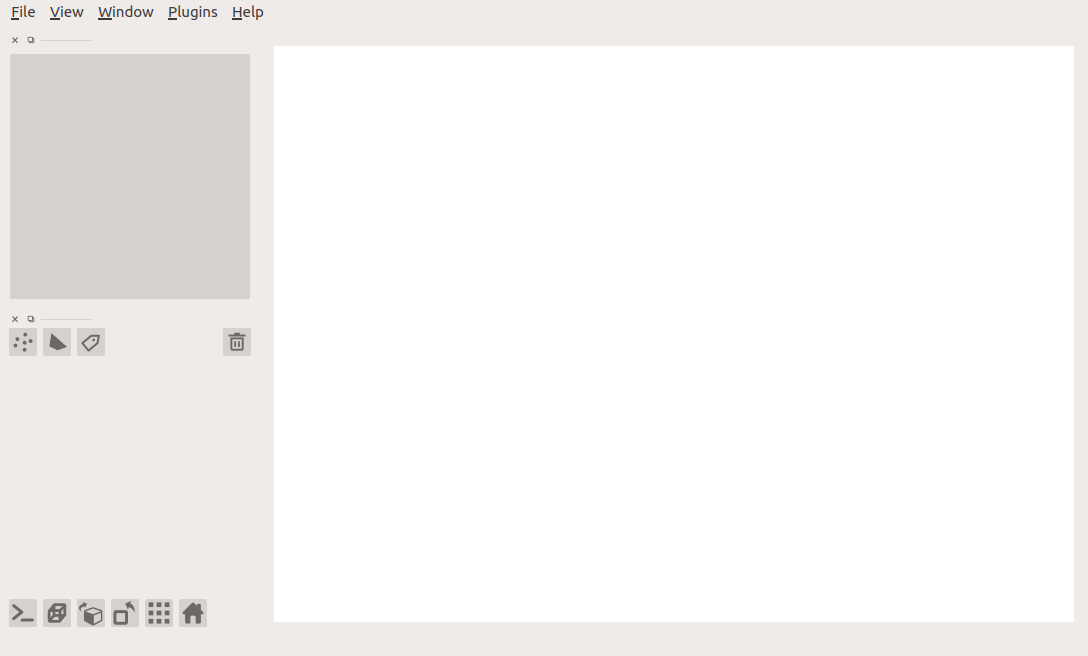

In [41]:
logging.getLogger('tifffile').setLevel(logging.ERROR)

viewer = napari.Viewer()
viewer.theme='light'
nbscreenshot(viewer)

And then add the `frame_list`

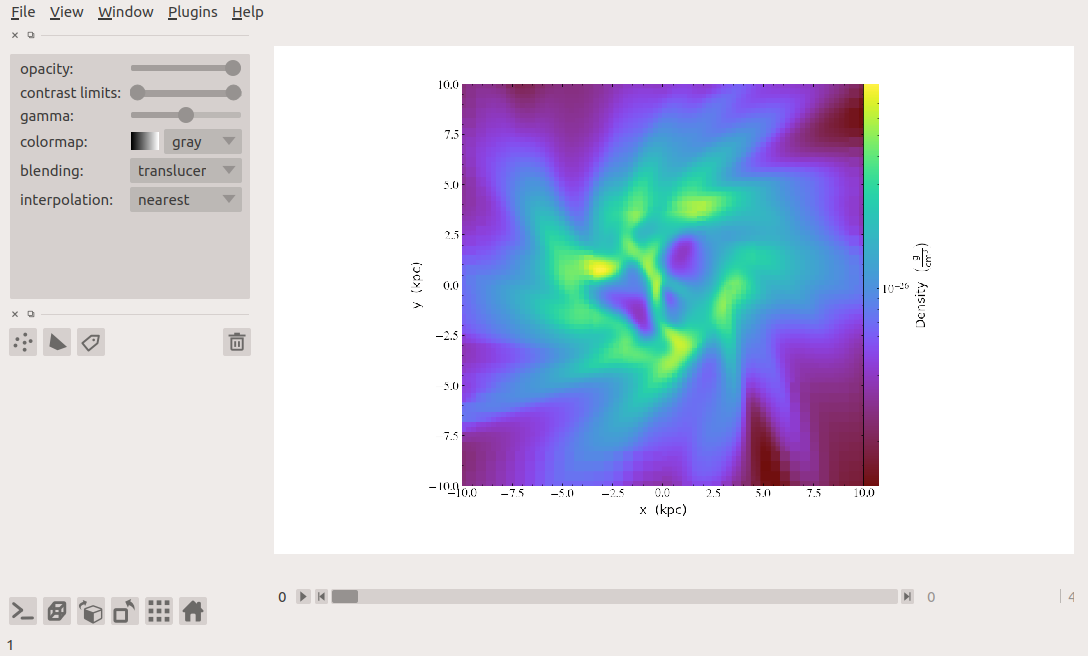

In [42]:
viewer.add_image(frame_list, multiscale = False);
nbscreenshot(viewer)

The slider at the bottom will move us through the domain. 

## 2. Viewing a lazy-processed dask-*yt* image stack  in napari 

The most obvious way to leverage dask in this process is to transform the image frame loop into a stack of lazy dask processes, so that napari generates each frame as it's selected, following Lambert's [napari-dask-example notebook](https://github.com/tlambert03/napari-dask-example/blob/master/dask_napari.ipynb).

We'll be using `dask.delayed` and `dask.array as da` here. 

We'll start by creating a function to process each frame:

In [43]:
def return_frame(zval):
    slc = yt.SlicePlot(ds, 'z', 'density', center=[0.5, 0.5, zval],width=(20,'kpc'))
    canvas = slc.plots[('gas', 'density')].canvas    
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    return np.frombuffer(s, np.uint8).reshape((height, width, 4))

Now we pull out a sample frame and build our lazy "reader" by giving it our `return_frame` function:

In [44]:
sample = return_frame(z_vals[0])
lazy_frame = delayed(return_frame)  # our lazy "reader"

Before building up our image stack, let's increase the number of frames to create:

In [45]:
z_dist=.005
Nframes = 500
z_vals = np.linspace(0.5-z_dist,0.5+z_dist,Nframes)

Now we need to build up our lazy loaded arrays into an image stack: 

In [46]:
lazy_arrays = [lazy_frame(zval) for zval in z_vals]
dask_arrays = [
    da.from_delayed(lazy_array, shape=sample.shape, dtype=sample.dtype)
    for lazy_array in lazy_arrays
]

From which we build up a single dask array stack:

In [47]:
dask_stack = da.stack(dask_arrays, axis=0)
dask_stack

,Array,Chunk
Bytes,1.03 GB,2.07 MB
Shape,"(500, 662, 781, 4)","(1, 662, 781, 4)"
Count,1500 Tasks,500 Chunks
Type,uint8,numpy.ndarray


So we can see that if we tried to load these image frames into memory, we'd need about 1 GB. 

And to view in napari? Just give it the `dask_stack`! 

In [48]:
viewer.add_image(dask_stack)

<Image layer 'dask_stack' at 0x7f36dd5faad0>

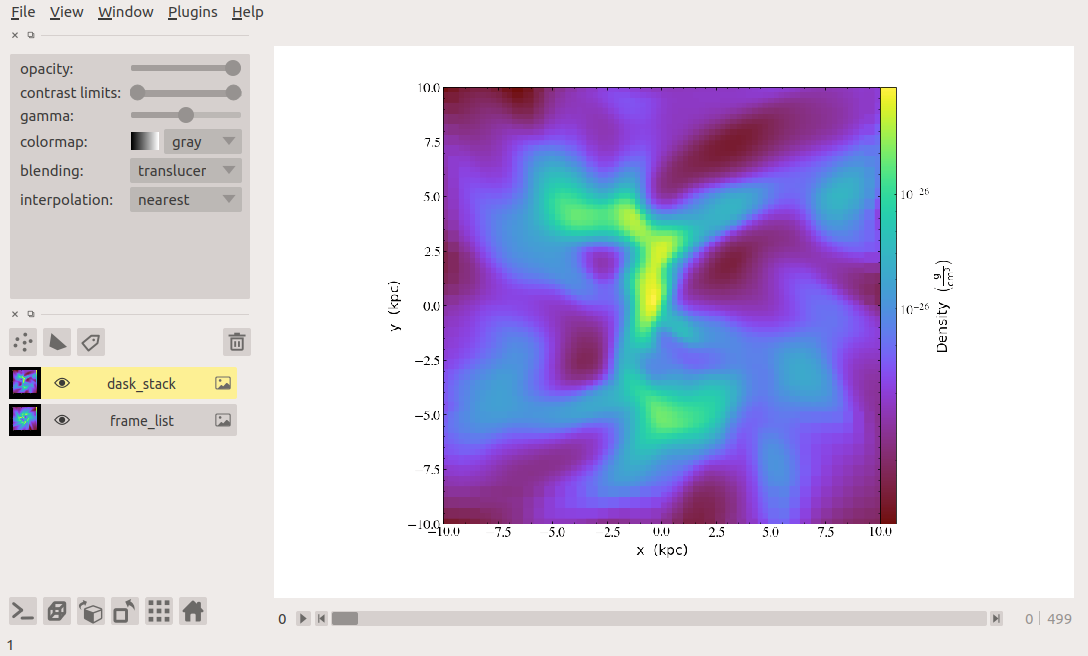

In [21]:
nbscreenshot(viewer)

And we see our new `dask_stack` has been added. Now when we slide the bottom slider, we'll traverse the volume but each frame will be loaded as needed. This approach does introduces a bit of lag -- changing frames takes about 1 second. That lags comes entirely from the slicing and rendering steps. 

## 3. Viewing a lazy-loaded dask-*yt* image stack from pre-computed *yt* slices in napari 

To reduce that lag, one option is to pre-compute all our slices, save them to disk then use dask's lazy loading with napari to access them. 

To speed this up, we can use dask to parallelize the pre-computation. So first let's import some more dask methods and boot up a client. Note that because *yt* uses matplotlib, this is **not** a thread-safe process, so we have to stick to 1 thread per worker here. 

This section will use `Client` from `dask.distributed` as well as `dask.compute`:

In [9]:
client = Client(threads_per_worker=1, n_workers=7)
client

Client Scheduler: tcp://127.0.0.1:35691 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 7 Memory: 33.24 GB


In [10]:
save_dir =os.path.join(yt.config.ytcfg.get("yt", "test_data_dir"),'testing_ytdasknapari')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

Great, we have a Client! Now we need to modify our fame function to save an image. And since we're using multiple workers here, we need to load the data set in each worker. Also, since we're using the `SlicePlot` save function, all the annotations and plot adjustments will be rendered prior to saving (unlike in the canvas draw method above), so let's normalize the colorbar and add a title with the z value before saving:

In [11]:

def save_frame(frame_id):  
    svnm = os.path.join(save_dir,f"slice_{frame_id}.png")
    if not os.path.isfile(svnm):
        # not thread-safe
        ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")
        zval = z_vals[frame_id]
        slc = yt.SlicePlot(ds, 'z', 'density', center=[0.5, 0.5, zval],width=(20,'kpc'))   
        slc.set_zlim('density',1e-30,1e-23)
        slc.annotate_title(f"z = {zval}")
        slc.save(svnm)
    return svnm


Now we construct our lazy saver and then compute

In [12]:
lazy_save = delayed(save_frame)  # our lazy "saver"
lazy_saves = [lazy_save(frame_id) for frame_id in range(len(z_vals))]


In [13]:
%%time 
filenames = compute(*lazy_saves);

CPU times: user 540 ms, sys: 32.5 ms, total: 572 ms
Wall time: 7.15 s


This will take a bit of time -- even in parallel with 7 cores, saving 500 images on my laptop took about 7 minutes. But now we can build our lazy loader, which at this point we can just borrow directly from [Lambert's Notebook](https://github.com/tlambert03/napari-dask-example/blob/master/dask_napari.ipynb). This loader just wraps matplotlib's `imread` function to make it lazy:  

In [ ]:
# cleanup: 
client.shutdown()

In [14]:

# open the first file to get shape and dtype
sample = plt.imread(filenames[0])

# create dask stack of lazy image readers
lazy_imread = delayed(plt.imread)  # lazy reader
lazy_arrays = [lazy_imread(fn) for fn in filenames]
dask_arrays = [
    da.from_delayed(lazy_array, shape=sample.shape, dtype=sample.dtype)
    for lazy_array in lazy_arrays
]
# Stack into one large dask.array
dask_rd_stack = da.stack(dask_arrays, axis=0)
dask_rd_stack

,Array,Chunk
Bytes,798.56 MB,15.97 MB
Shape,"(50, 920, 1085, 4)","(1, 920, 1085, 4)"
Count,150 Tasks,50 Chunks
Type,float32,numpy.ndarray


And now we load into napari again! Because the size of our images are different from the above ones, we'll open a new viewer: 

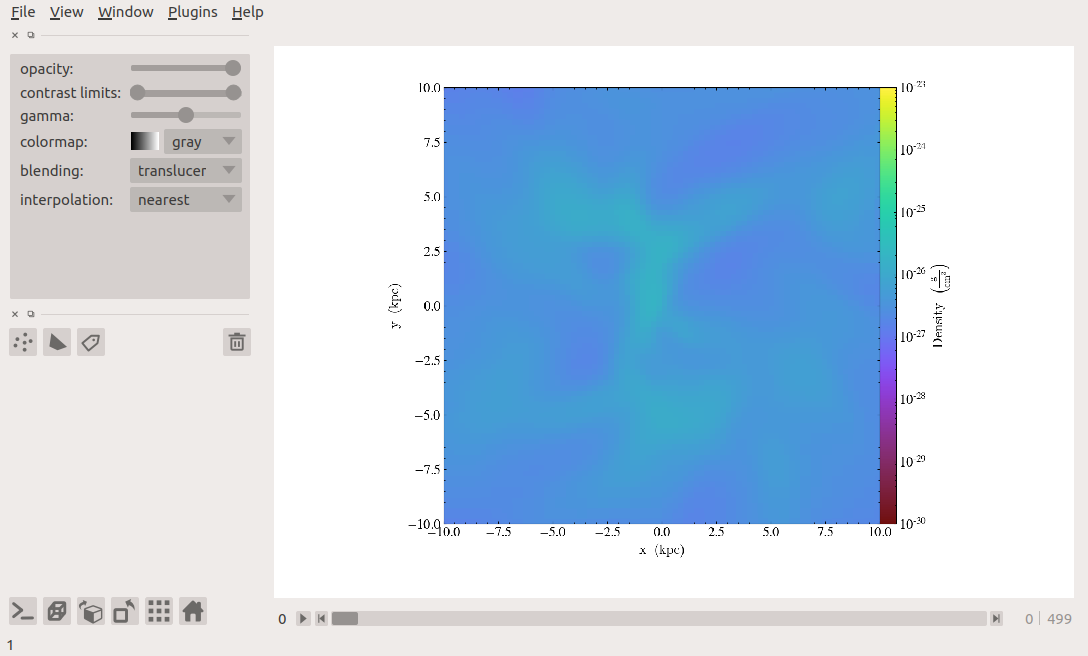

In [39]:
viewer = napari.Viewer()
viewer.theme='light'
viewer.add_image(dask_rd_stack)
nbscreenshot(viewer)

Traversing the z level is much more responsive now -- albeit at the initial expense of ~5-10 mins of pre-computation. 

## 4. one more approach with *yt*'s fixed resolution buffer

Throughout the above examples, we've simply been using napari as a front end image viewer -- since we're loading in images with pre-existing axes, colorbars and colormaps we don't have much use for napari's built in image adjustment. But what if we want to load slice data in directly and let napari handle the color mapping? 

By using *yt*'s `FixedResolutionBuffer` (fbr) method, we can extract a simple 2D image array of our slice (see the yt docs [here](https://yt-project.org/doc/visualizing/manual_plotting.html) for a more in depth description):

In [23]:
# %%timeit
sl = ds.slice('z',z_vals[0])
width = (20, 'kpc') 
res = [800, 800] 
frb = sl.to_frb(width, res, center = [.5,.5,z_vals[0]])
dens = np.array(frb['density'])


The `dens` array is just a 2D image array:

In [24]:
dens.shape

(800, 800)

that we can plot with 

In [25]:
dens[0:10,0:3]

array([[1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.54102583e-27, 1.54102583e-27, 1.54102583e-27],
       [1.73984490e-27, 1.73984490e-27, 1.73984490e-27]])

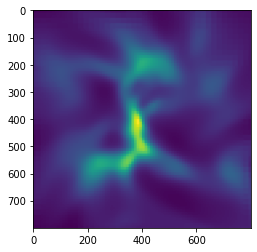

In [26]:
plt.imshow(dens)

But since extracting the slice data was fairly fast (40 ms compared to a few seconds to generate a yt image), we may be able to use a lazy process to visualize on demand without lag -- let's try it out! 

In [27]:
yt.funcs.mylog.setLevel(50)


In [49]:
z_dist=.01
Nframes = 1000
z_vals = np.linspace(0.5-z_dist,0.5+z_dist,Nframes)

In [50]:
ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")
width = (20, 'kpc') 
res = [800, 800] 
nwshp=(800,800,1)
def return_frame_slice(zval):    
    sl = ds.slice('z',zval)    
    frb = sl.to_frb(width, res, center = [.5,.5,zval])   
    return np.log10(np.array(frb['density']))

In [51]:
sample = return_frame_slice(z_vals[0])
lazy_frame_direct = delayed(return_frame_slice)  # our lazy "reader"


lazy_arrays = [lazy_frame_direct(zval) for zval in z_vals]
dask_arrays = [
    da.from_delayed(lazy_array, shape=sample.shape, dtype=sample.dtype)
    for lazy_array in lazy_arrays
]

dask_stack_direct = da.stack(dask_arrays, axis=0)
dask_stack_direct

Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 15027.74it/s]


,Array,Chunk
Bytes,5.12 GB,5.12 MB
Shape,"(1000, 800, 800)","(1, 800, 800)"
Count,3000 Tasks,1000 Chunks
Type,float64,numpy.ndarray


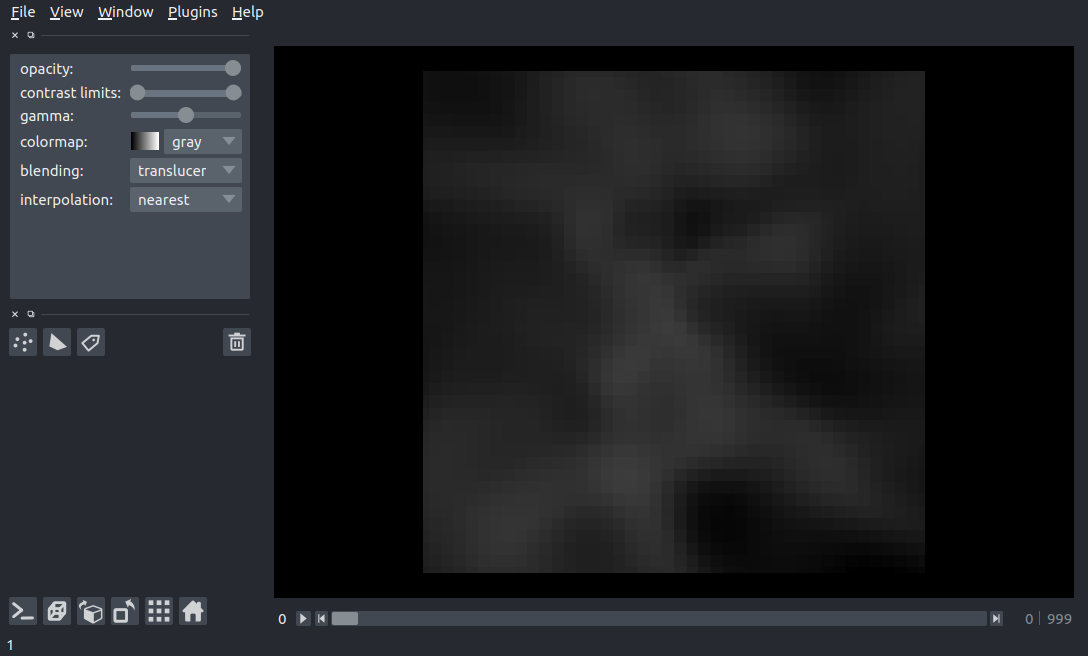

In [52]:
viewer = napari.Viewer()
viewer.add_image(dask_stack_direct)
nbscreenshot(viewer)



Wow!! No visible lag, can use the built in colormaps! 

## final thoughts

While there are certainly ways to improve how we're loading *yt* data products into napari here, it is impressive just how **easy** all of this is. By stringing together 3 different open source projects across the python ecosystem, we have instant support for wider audiences than each package has alone: *yt* users can explore their data in more interactive ways and napari users can essentially use *yt* as a back end data visualizer for any of the data formats supported by *yt*, all beneath the dask umbrella!  
